In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A

import os
from glob import glob
import requests
import random
from time import time
from enum import Enum
from pprint import pprint

# Loss

In [2]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2., reduction='mean'):
        nn.Module.__init__(self)

        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)

        return F.nll_loss(((1-prob)**self.gamma)*log_prob, target_tensor, weight=self.weight, reduction=self.reduction)


class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes=3, smoothing=0., dim=-1):
        super(LabelSmoothingLoss, self).__init__()

        self.confidence = 1. - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):

        pred = pred.log_softmax(dim=self.dim)

        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing/(self.cls-1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)

        return torch.mean(torch.sum(-true_dist*pred, dim=self.dim))


class F1Loss(nn.Module):
    def __init__(self, classes=3, epsilon=1e-7):
        super().__init__()

        self.classes = classes
        self.epsilon = epsilon

    def forward(self, y_pred, y_true):

        assert y_pred.ndim==2
        assert y_true.ndim==1

        y_true = F.one_hot(y_true, self.classes).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)

        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2 * (precision * recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1 - self.epsilon)
        
        return 1 - f1.mean()

In [4]:
criterion_entrypoints = {
    'cross_entropy': nn.CrossEntropyLoss,
    'focal': FocalLoss,
    'label_smoothing': LabelSmoothingLoss,
    'f1': F1Loss
}

def create_criterion(criterion_name):
    return criterion_entrypoints[criterion_name]

In [16]:
criterion = create_criterion('label_smoothing')

# Optimizer

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.hidden = nn.Linear(1, 20)
        self.predict = nn.Linear(20, 1)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.predict(x)
        return x

In [7]:
LR = 0.01 
BATCH_SIZE = 32 
EPOCH = 15 

In [17]:
x = torch.unsqueeze(torch.linspace(-1,1,1000), dim=1)
y = x.pow(2) + 0.1*torch.normal(torch.zeros(x.size()))

dataset = torch.utils.data.TensorDataset(x,y)
dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

In [10]:
net_SGD = Net()
net_Adam = Net()
nets = [net_SGD, net_Adam]

opt_SGD = torch.optim.SGD(net_SGD.parameters(), lr=LR)
opt_Adam = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))
optimizers = [opt_SGD, opt_Adam]

loss_func = torch.nn.MSELoss()
losses_his = [[],[]]

In [18]:
for epoch in range(EPOCH):

    for step, (batch_x, batch_y) in enumerate(dataloader):
        
        b_x = Variable(batch_x)
        b_y = Variable(batch_y)
                
        for net, opt, l_his in zip(nets, optimizers, losses_his):
            output = net(b_x) 
            loss = loss_func(output, b_y)
            
            opt.zero_grad() 
            loss.backward() 
            opt.step() 
            
            l_his.append(loss.item()) 

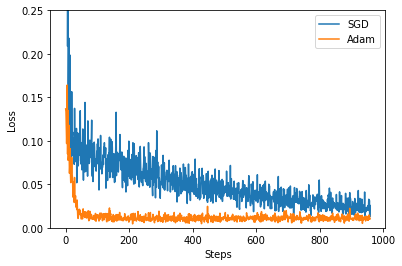

In [20]:
labels = ['SGD', 'Adam']

for i, l_his in enumerate(losses_his):
    plt.plot(l_his, label=labels[i])

plt.legend(loc='best')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.ylim(0, 0.25)  
plt.show()